In [715]:
cd Documents/Python/NYC Data/

/Users/maxcohen/Documents/Python/NYC Data


In [565]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import geopandas as gpd
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf
from scipy.stats import gaussian_kde
import seaborn as sns
from shapely.geometry import shape, Point
import swifter
import censusgeocode as cg
from mpl_toolkits.axes_grid1 import make_axes_locatable

POSSIBLE AREAS OF INTEREST

What crimes disproprtionatly affect black people?
- Search for Marijuana in the arrest dataset
    - Are marijuana crimes more likely to result in serious charges for black people?
    
Where do certain arrests happen?
- Where are people arrested for marijuana? Robbery? Sexual assault?

Gender or age differences?

What precincts are the "worst"?

Map the racial arrest gap
The goal here is to create a visualization of where black people are disproportionatly arrested
- Most readily done by finding the census demographics at each arrest lat/lon
    - Then compare the census demo to the arrest demo and determine how far off it is
    - For example: in x census tract, black people make up 30% of the population but are 75% of the arrests

Sources
- NYC Centerline Data 
-- https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b
- NYTimes Mapping Segregation
-- https://www.nytimes.com/interactive/2015/07/08/us/census-race-map.html?mtrref=www.google.com&assetType=PAYWALL
- US Census Population Data
-- https://www.census.gov/quickfacts/fact/table/kingscountybrooklynboroughnewyork,newyorkcitynewyork/PST045219
- Racial Dot Map
-- http://racialdotmap.demographics.coopercenter.org/
- NYPD Precincts Map
-- https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz
- NYPD Arrests Data
-- https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u
- NYC Census Tracts Data
-- https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
- ACS Tables
-- https://data.census.gov/cedsci/
- NHGIS
-- https://data2.nhgis.org/main

Important Resources
- https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/
- https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/
- https://datashader.org/getting_started/Introduction.html
- https://seaborn.pydata.org/generated/seaborn.kdeplot.html
- http://andrewgaidus.com/Dot_Density_County_Maps/
- https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9

### LOAD ALL DATA

In [83]:
#census tract map of Brooklyn
census_tracts = gpd.read_file(
    '2010 Census Tracts/geo_export_7c8515b7-143e-4d01-972b-35868adf5281.shp')
bk_census_tracts = census_tracts[census_tracts['boro_name'] == 'Brooklyn']

In [87]:
#ACS census tract demo data
acs_demo = pd.read_csv('ACS5yearBK/ACS5yearBK_data.csv', skiprows=1)
#ACS census tract demo data dictionary
acs_data_dict = pd.read_csv('ACS5yearBK/ACS5yearBK_data_dict.csv',skiprows=1)

In [718]:
pd.read_csv('ACS5yearBK/ACS5yearBK_data_dict.csv',skiprows=1)

NAME                               Geographic Area Name  \
0     DP05_0001E            Estimate!!SEX AND AGE!!Total population   
1     DP05_0001M     Margin of Error!!SEX AND AGE!!Total population   
2    DP05_0001PE    Percent Estimate!!SEX AND AGE!!Total population   
3    DP05_0001PM  Percent Margin of Error!!SEX AND AGE!!Total po...   
4     DP05_0002E      Estimate!!SEX AND AGE!!Total population!!Male   
..           ...                                                ...   
351  DP05_0088PM  Percent Margin of Error!!CITIZEN, VOTING AGE P...   
352   DP05_0089E  Estimate!!CITIZEN, VOTING AGE POPULATION!!Citi...   
353   DP05_0089M  Margin of Error!!CITIZEN, VOTING AGE POPULATIO...   
354  DP05_0089PE  Percent Estimate!!CITIZEN, VOTING AGE POPULATI...   
355  DP05_0089PM  Percent Margin of Error!!CITIZEN, VOTING AGE P...   

     Unnamed: 2  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
351         NaN  
352         NaN  
353         NaN  
354         NaN  
355         NaN  

[356 rows x 3 columns]

In [2]:
#street centerline map of nyc
our_streets = gpd.read_file('NYC Street Centerline (CSCL)/geo_export_c00f9a7a-d11b-4436-bc33-9fcb9a060d9d.shp')

In [100]:
#Borough Codes
# 1-Man 2-Bronx 3-Brooklyn 4-Queens 5-Staten Island
#brooklyn streets
bk_base = (our_streets[(our_streets['borocode'] == '3') & #brooklyn=3 
                       (our_streets['rw_type'] != 14)]) #remove ferry routes

In [620]:
notbk_base = (our_streets[(our_streets['borocode'] != '3') & #brooklyn=3 
                       (our_streets['rw_type'] != 14)]) #remove ferry routes

In [101]:
#read column dictionary
xls = pd.ExcelFile('NYPD_Arrest_Historic_DataDictionary.xlsx')
arrest_col_info = pd.read_excel(xls, 'Column Info', header=1)
#delete filler columns with NaN vals
col_info = col_info.drop(columns=list(col_info.columns[2:]))

In [6]:
#read arrests file
df = pd.read_csv('NYPD_Arrests_Data__Historic_.csv')

### CLEAN ARRESTS DATA

In [103]:
#limit arrest file to Brooklyn
df = df[ (df['Latitude'] < 40.8) & (df['ARREST_BORO'] == 'K') ]

In [7]:
#change arrest dates to datetime
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'])

In [8]:
#number of unique values in all of the arrest description columns'
for i in df.columns[2:8]:
    uni_vals = len(df[i].value_counts().sort_values(ascending=False))
    print(str(i) + ' | ' + str(uni_vals))

PD_CD | 334
PD_DESC | 418
KY_CD | 75
OFNS_DESC | 86
LAW_CODE | 2416
LAW_CAT_CD | 4


In [9]:
#limit jurisdiction codes to 0->3
df['JURISDICTION_CODE'] = df['JURISDICTION_CODE'].apply(lambda x: 3 if x>2 else x)

In [10]:
#Limit age groups to 6 main categories
#First, create the list of the 6 main category labels
age_groups = df['AGE_GROUP'].value_counts().sort_values(ascending=False)[:5].index.to_list()

In [11]:
#Write eveything that is not in one of these categories as NaN
df['AGE_GROUP'] = df['AGE_GROUP'].apply(lambda x: np.nan if x not in age_groups else x)

In [12]:
#turn all of those NaN age_group values into real age groups based on the proportion of age groups in the data
#1. make a dictionary of the age groups and their percentages in the data
age_group_dict = dict(df['AGE_GROUP'].value_counts(normalize=True))
age_group_keys = list(age_group_dict.keys())
age_group_values = list(age_group_dict.values())
#2. randomly fillna with the proportion of each value
df['AGE_GROUP'] = df['AGE_GROUP'].fillna(
    pd.Series(np.random.choice(age_group_keys, p=age_group_values, size=len(df))))

In [14]:
#Group "black hispanic" and "white hispanic" into "hispanic"
#This could be flawed
#*** Before combining, "White Hispanic" was 26% and "Black Hispanic" was 8% ***
df['PERP_RACE'] = df['PERP_RACE'].apply(lambda x: 'HISPANIC' if x.endswith('HISPANIC') else x)

Split dates into the following:
    - Year
    - Month #
    - Day # of month
    - Weekday name (optional)
    - Day of year (optional)

In [15]:
df['ARREST_YEAR'] = df['ARREST_DATE'].apply(lambda x: x.year)
df['ARREST_MONTH'] = df['ARREST_DATE'].apply(lambda x: x.month)
df['ARREST_DAY'] = df['ARREST_DATE'].apply(lambda x: x.day)

In [105]:
#most common arresting precincts
df['ARREST_PRECINCT'].value_counts().sort_values(ascending=False)

75     171855
73     138429
79      91083
67      88629
83      79377
77      77582
70      69708
71      65865
60      63197
81      62318
84      60479
90      52706
72      51415
61      42255
69      39900
88      36229
62      35155
68      32542
63      31540
76      29129
78      26467
66      24892
94      21906
104         1
106         1
Name: ARREST_PRECINCT, dtype: int64

### DEOMGRAPHICS AND ACS DATA CLEANING

This is an early attempt to normalize data for the underlying demographics

Black people are 33.9% of the BK population, but account for 61.9% of the arrests

In [104]:
df['PERP_RACE'].value_counts(normalize=True)

BLACK                             0.618931
HISPANIC                          0.228247
WHITE                             0.119901
ASIAN / PACIFIC ISLANDER          0.024745
UNKNOWN                           0.006313
AMERICAN INDIAN/ALASKAN NATIVE    0.001692
OTHER                             0.000172
Name: PERP_RACE, dtype: float64

The goal here is to create a visualization of where black people are disproportionatly arrested
- Most readily done by finding the census demographics at each arrest lat/lon
    - Then compare the census demo to the arrest demo and determine how far off it is
    - For example: at x,x black people make up 50% of the population but are 75% of the arrests
   
Handling "Hispanic" census data
- https://www.census.gov/topics/population/hispanic-origin/about/comparing-race-and-hispanic-origin.html
- With the ACS data, we are looking for black people which should all be covered in the "race" categories

- Data steps
    1. XXX Create ACS column that corresponds to census tract names
    2. XXX Collect all the relevant demographics columns in ACS dataframe
    3. XXX Merge the census tract data with the demographic data (or vice verse)
    4. XXX Once those are merged, we have the following:
        - Demo data for each cesnsus tract in Brooklyn
        - Shapefile data for each census tract in BK
    5. XXX Associate each arrest location with a census tract based on the lat/lon data
        - Something like a lambda function that looks at each lat/lon and puts it into a specific census tract
    6. Now we can group by each lat/lon and compare arrest demos to the baseline residency demos

In [128]:
#remove margin of error columns
acs_demo = acs_demo[acs_demo.columns.drop(list(acs_demo.filter(regex='Margin of Error')))]

In [151]:
#create ctlabel column with just the "number" name of census tract
#now this will match the bk_census_tract column
acs_demo['ctlabel'] = acs_demo['Geographic Area Name'].apply(lambda x: x.split('Census Tract ')[1].split(', Kings County')[0])

/Users/maxcohen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#Clean up column names
#Attempt to only take "percent estimate" and the final thing, but that doesn't always work
#list(acs_demo.columns)[3][::-1].split('!!')[0][::-1] + '_' + list(acs_demo.columns)[3][::-1].split('!!')[-1][::-1]

In [173]:
#acs_demo.to_csv('ACS5yearBK/ACS5yearBK_data.csv')

In [172]:
list(acs_demo.columns)

['id',
 'Geographic Area Name',
 'Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females)',
 'Percent Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females)',
 'Estimate!!RACE!!Total population',
 'Percent Estimate!!RACE!!Total population',
 'Estimate!!RACE!!Total population!!One race',
 'Percent Estimate!!RACE!!Total population!!One race',
 'Estimate!!RACE!!Total population!!Two or more races',
 'Percent Estimate!!RACE!!Total population!!Two or more races',
 'Estimate!!RACE!!Total population!!One race.1',
 'Percent Estimate!!RACE!!Total population!!One race.1',
 'Estimate!!RACE!!Total population!!One race!!White',
 'Percent Estimate!!RACE!!Total population!!One race!!White',
 'Estimate!!RACE!!Total population!!One race!!Black or African American',
 'Percent Estimate!!RACE!!Total population!!One race!!Black or African American',
 'Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native',


In [180]:
#columns that account for all black people (of one race or multiple) in a given census tract
black_pop_columns = ['Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American',
                     'Percent Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American']

In [185]:
#add census tract label to the list so that we can create an abbreviated dataframe
black_pop_columns.insert(0,'ctlabel')

In [191]:
#filter dataframe to only include black population columns
ct_black_pop = acs_demo[black_pop_columns]

In [197]:
#census tract lengths are different, find out which one
#after looking, census tract 9901 from the ACS data has no population, so I will ignore it
pd.Index(ct_black_pop.ctlabel).difference(pd.Index(bk_census_tracts.ctlabel)).values

array(['9901'], dtype=object)

In [203]:
#merge the black pop data onto the bk_census_tracts (shortened to just geometry and census tract name)
ct_black_pop = bk_census_tracts[['ctlabel','geometry']].merge(ct_black_pop, on='ctlabel')

In [208]:
#rename columns
ct_black_pop.rename(columns={'Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American':'total_pop',
                            'Percent Estimate!!Race alone or in combination with one or more other races!!Total population!!Black or African American':'perc_pop'},
                   inplace=True)

5. Associate each arrest location with a census tract based on the lat/lon data
        - Something like a lambda function that looks at each lat/lon and puts it into a specific census tract
        
If lat/lon is in a polygon, return that polygon in a new column 
then df.merge(ct_black_pop, on='geometry')

In [323]:
#combine lat/lon into one column
df['lonlat'] = list(zip(df['Longitude'], df['Latitude']))

In [324]:
#convert lat/lon into "points"
df['point'] = df['lonlat'].apply(lambda x: Point(x))

In [347]:
#copy the geometry column because we will need a copy when we join the dataframes
ct_black_pop['ctpoly'] = ct_black_pop['geometry']

In [331]:
#turn df into a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'],df['Latitude']))

In [350]:
#sjoin arrest df with black pop df on the geometry column (left=point, right=polygon)
#sjoin determines if the point is intersecting any part of the polygon
#THIS IS SO SIIIIICK
#and is so faaaaast
%time
gdf = gpd.sjoin(gdf, ct_black_pop, how='left', op='intersects')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs


/Users/maxcohen/opt/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [358]:
#remove NAs
gdf.dropna(inplace=True)

In [680]:
#Function creates a dataframe that is grouped by a geo tag and then returns a new dataframe 
    #of racial disparity in arrests at that geo tag
def geo_combine_arrest_pop(cols):
    geo_race = gdf.groupby(cols).size()\
    .groupby(level=[0])\
    .apply(lambda x: 100 * x / float(x.sum()))\
    .reset_index()\
    .rename(columns={0:'perc_arrest'})
    geo_race_black = geo_race[geo_race['PERP_RACE'] == 'BLACK']
    geo_combo_arrest_pop = geo_race_black.merge(ct_black_pop[['ctlabel','perc_pop','total_pop','geometry']], 
                                                on='ctlabel')
    geo_combo_arrest_pop['perc_pop'] = geo_combo_arrest_pop['perc_pop'].replace('-','0.0').astype('float')
    geo_combo_arrest_pop['diff'] = geo_combo_arrest_pop['perc_arrest'] - geo_combo_arrest_pop['perc_pop']
    geo_combo_arrest_pop = gpd.GeoDataFrame(geo_combo_arrest_pop, geometry=geo_combo_arrest_pop['geometry'])
    return geo_combo_arrest_pop

In [681]:
ct_combo_arrest_pop = geo_combine_arrest_pop(['ctlabel','PERP_RACE'])

In [505]:
diff.max()

62.14252873563218

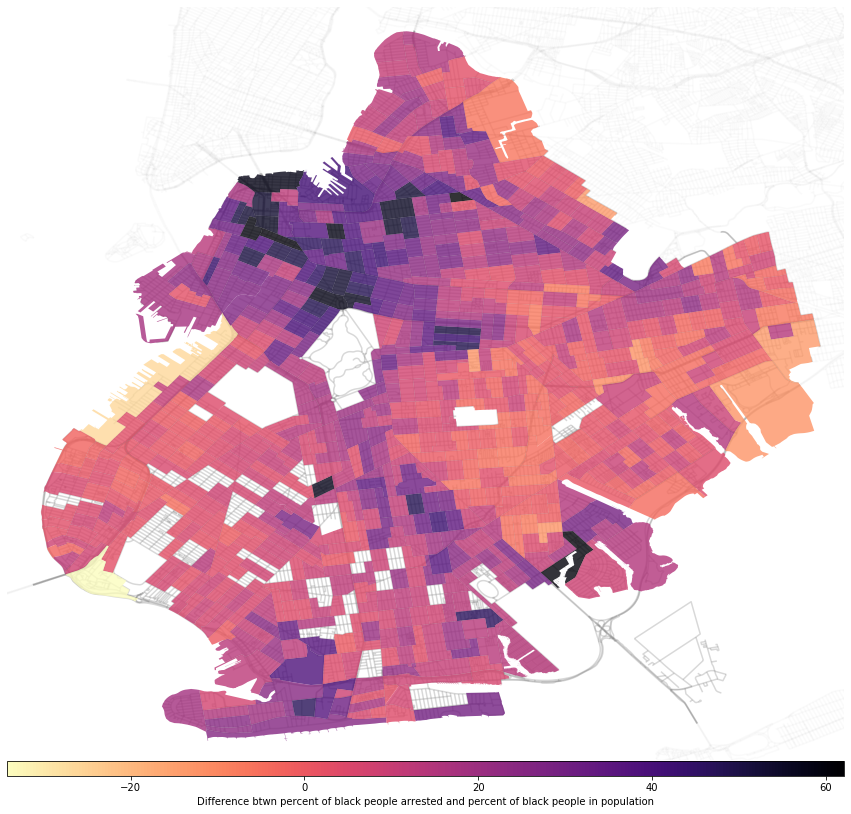

In [637]:
#brooklyn census tracts
fig,ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)

bk_base.plot(ax=ax, color='grey', alpha=.3, zorder=2)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)


pop0_filt = ct_combo_arrest_pop[ct_combo_arrest_pop['total_pop'] > 0]
diff = pop0_filt['diff']
pop0_filt.plot(ax=ax, column=diff, cmap='magma_r', alpha=.8, zorder=3, 
               legend=True, cax=cax,
               legend_kwds={'label':'Difference btwn percent of black people arrested and percent of black people in population',
                            'orientation':'horizontal'})

declutter_axes(ax=ax)

ax.set_xlim(-74.050,-73.850)
ax.set_ylim(40.565,40.745)

plt.savefig('figs/arrest_disparity_by_census_tract.png', 
            dpi=500, bbox_inches='tight')
plt.show()

In [642]:
#groupby to find the percent of each race that was arrested within each latlon
lonlat_race = gdf.groupby(['Longitude','Latitude','PERP_RACE']).size()\
.groupby(level=[0])\
.apply(lambda x: 100 * x / float(x.sum()))\
.reset_index()\
.rename(columns={0:'perc_arrest'})

In [687]:
lonlat_combo_arrest_pop = geo_combine_arrest_pop(['Longitude','Latitude','ctlabel','PERP_RACE'])

In [688]:
lonlat_combo_arrest_pop.head()

Longitude   Latitude ctlabel PERP_RACE  perc_arrest  perc_pop  total_pop  \
0 -74.040716  40.624563      50     BLACK         12.5       1.9         45   
1 -74.039688  40.623965      50     BLACK         50.0       1.9         45   
2 -74.038345  40.623647      50     BLACK         25.0       1.9         45   
3 -74.037285  40.622645      50     BLACK         20.0       1.9         45   
4 -74.036868  40.623666      50     BLACK        100.0       1.9         45   

                                            geometry  diff  
0  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  10.6  
1  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  48.1  
2  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  23.1  
3  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  18.1  
4  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  98.1

In [705]:
pop0_filt

Longitude   Latitude ctlabel PERP_RACE  perc_arrest  perc_pop  \
0     -74.040716  40.624563      50     BLACK    12.500000       1.9   
1     -74.039688  40.623965      50     BLACK    50.000000       1.9   
2     -74.038345  40.623647      50     BLACK    25.000000       1.9   
3     -74.037285  40.622645      50     BLACK    20.000000       1.9   
4     -74.036868  40.623666      50     BLACK   100.000000       1.9   
...          ...        ...     ...       ...          ...       ...   
20795 -73.863830  40.666007    1214     BLACK    76.190476      66.6   
20796 -73.863711  40.666026    1214     BLACK    76.576577      66.6   
20797 -73.862950  40.666135    1214     BLACK    80.000000      66.6   
20798 -73.862788  40.666157    1214     BLACK   100.000000      66.6   
20799 -73.862045  40.666263    1214     BLACK    81.818182      66.6   

       total_pop                                           geometry       diff  
0             45  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  10.600000  
1             45  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  48.100000  
2             45  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  23.100000  
3             45  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  18.100000  
4             45  POLYGON ((-74.03311 40.62565, -74.03339 40.624...  98.100000  
...          ...                                                ...        ...  
20795       3140  POLYGON ((-73.86831 40.66867, -73.86775 40.668...   9.590476  
20796       3140  POLYGON ((-73.86831 40.66867, -73.86775 40.668...   9.976577  
20797       3140  POLYGON ((-73.86831 40.66867, -73.86775 40.668...  13.400000  
20798       3140  POLYGON ((-73.86831 40.66867, -73.86775 40.668...  33.400000  
20799       3140  POLYGON ((-73.86831 40.66867, -73.86775 40.668...  15.218182  

[20173 rows x 9 columns]

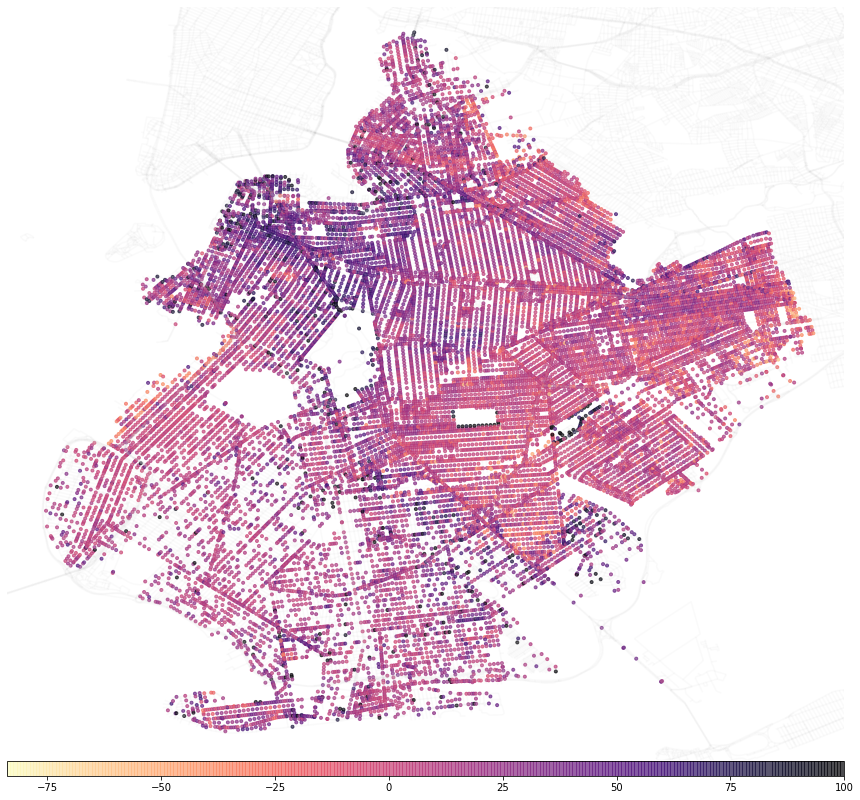

In [720]:
#brooklyn census tracts
fig,ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)

bk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=2)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)

pop0_filt = lonlat_combo_arrest_pop[lonlat_combo_arrest_pop['total_pop'] > 0]
diff = pop0_filt['diff']
im = ax.scatter(x=lonlat_combo_arrest_pop['Longitude'], y=lonlat_combo_arrest_pop['Latitude'], 
                marker='.', alpha=.7, c=lonlat_combo_arrest_pop['diff'], cmap='magma_r')

declutter_axes(ax=ax)

ax.set_xlim(-74.050,-73.850)
ax.set_ylim(40.565,40.745)

plt.colorbar(im, cax, orientation='horizontal')

plt.savefig('figs/arrest_disparity_by_latlon.png', dpi=500, bbox_inches='tight')
plt.show()

### SIMPLE CHARTS TO LOOK AT DATA

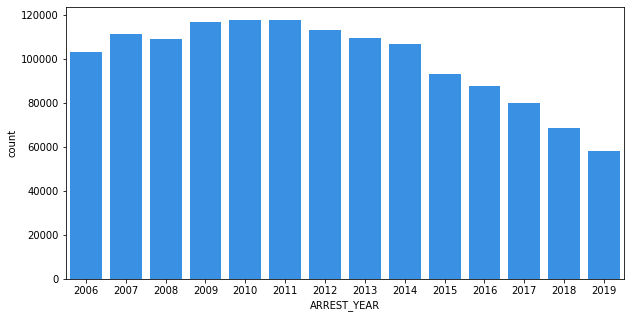

In [112]:
#arrests per year
fig,ax = plt.subplots(figsize=(10,5))

sns.countplot(x=df['ARREST_YEAR'], data=df, color='dodgerblue')
plt.show()

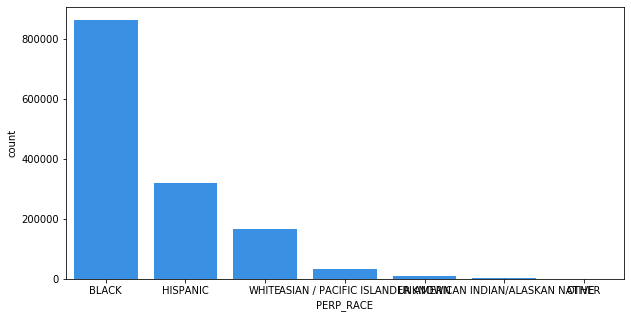

In [116]:
#arrest by race
fig,ax = plt.subplots(figsize=(10,5))

sns.countplot(x=df['PERP_RACE'], data=df, color='dodgerblue')
plt.show()

### MAPS

#an attempt at creating a baselayer function

def bk_base():
    #brooklyn streets baselaye
    fig,ax = plt.subplots(figsize=(15,15))

    bk_base = (our_streets[(our_streets['borocode'] == '3') & #brooklyn=3 
                           (our_streets['rw_type'] != 14) & #remove ferry routes
                           (our_streets['l_zip'] != '11693')]) #remove a sliver of a street in Jamaica Bay

    bk_base.plot(ax=ax, color='grey', alpha=.7)

    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_xticklines()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    return ax

bk_base()

In [22]:
#a function to remove axes spines, ticks, and labels
def declutter_axes(ax=None):
    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_xticklines()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    return ax

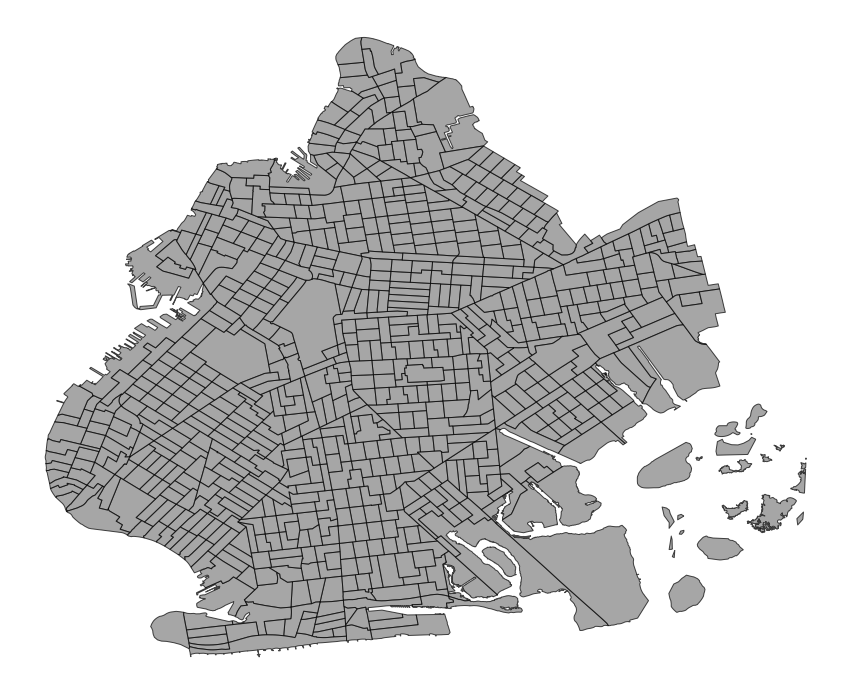

In [121]:
#brooklyn census tracts
fig,ax = plt.subplots(figsize=(15,15))

bk_census_tracts.plot(ax=ax, color='grey', alpha=.7, edgecolor='black')

declutter_axes(ax=ax)

plt.show()

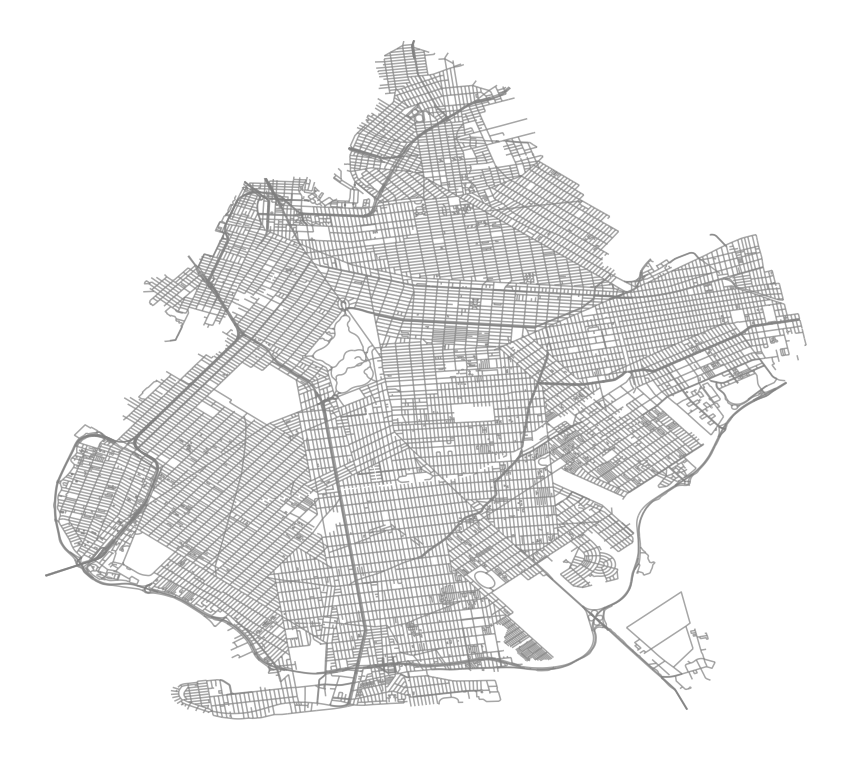

In [122]:
#brooklyn streets baselayer
fig,ax = plt.subplots(figsize=(15,15))
           
bk_base.plot(ax=ax, color='grey', alpha=.7)

declutter_axes(ax=ax)

plt.show()

### Map some different arrest data in Brooklyn

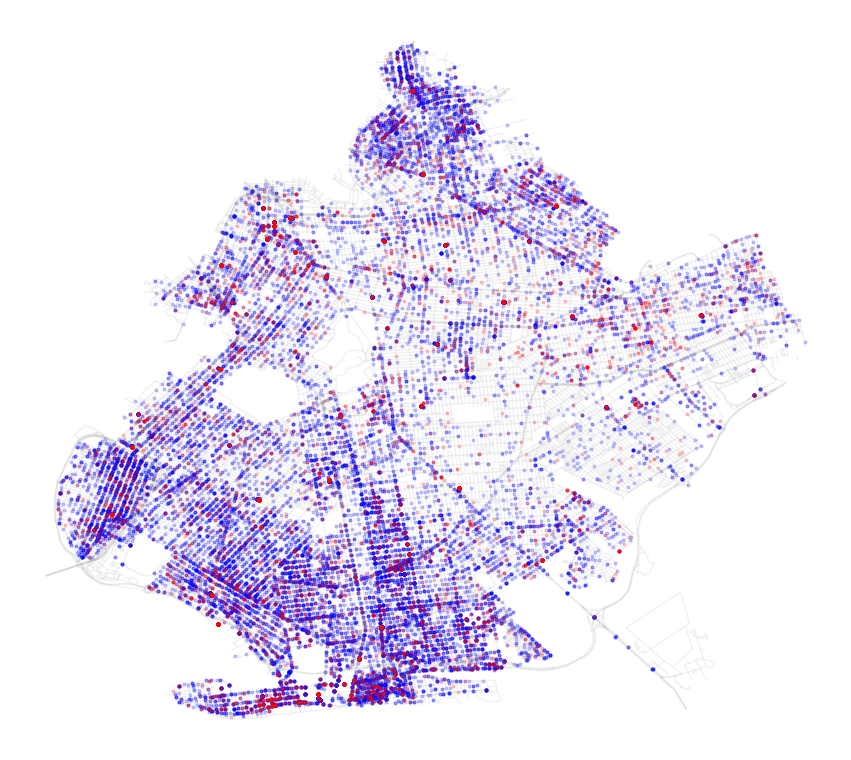

In [24]:
#White felony arrests in Brooklyn by gender 
fig,ax = plt.subplots(figsize=(15,15))

bk_base.plot(ax=ax, color='grey', alpha=.1)

ax.scatter(df[ (df['Latitude'] < 40.8) & 
              (df['ARREST_BORO'] == 'K') & 
              (df['PERP_RACE'] == 'WHITE') & 
              (df['LAW_CAT_CD'] == 'F') & 
              (df['PERP_SEX'] == 'M')]['Longitude'], 
            df[ (df['Latitude'] < 40.8) & 
               (df['ARREST_BORO'] == 'K') & 
               (df['PERP_RACE'] == 'WHITE') & 
               (df['LAW_CAT_CD'] == 'F') & 
               (df['PERP_SEX'] == 'M')]['Latitude'], 
            marker='.', alpha=.2, color='blue')

ax.scatter(df[ (df['Latitude'] < 40.8) & 
              (df['ARREST_BORO'] == 'K') & 
              (df['PERP_RACE'] == 'WHITE') & 
              (df['LAW_CAT_CD'] == 'F') & 
              (df['PERP_SEX'] == 'F')]['Longitude'], 
            df[ (df['Latitude'] < 40.8) & 
               (df['ARREST_BORO'] == 'K') & 
               (df['PERP_RACE'] == 'WHITE') & 
               (df['LAW_CAT_CD'] == 'F') & 
               (df['PERP_SEX'] == 'F')]['Latitude'], 
            marker='.', alpha=.2, color='red')

declutter_axes(ax=ax)

plt.show()

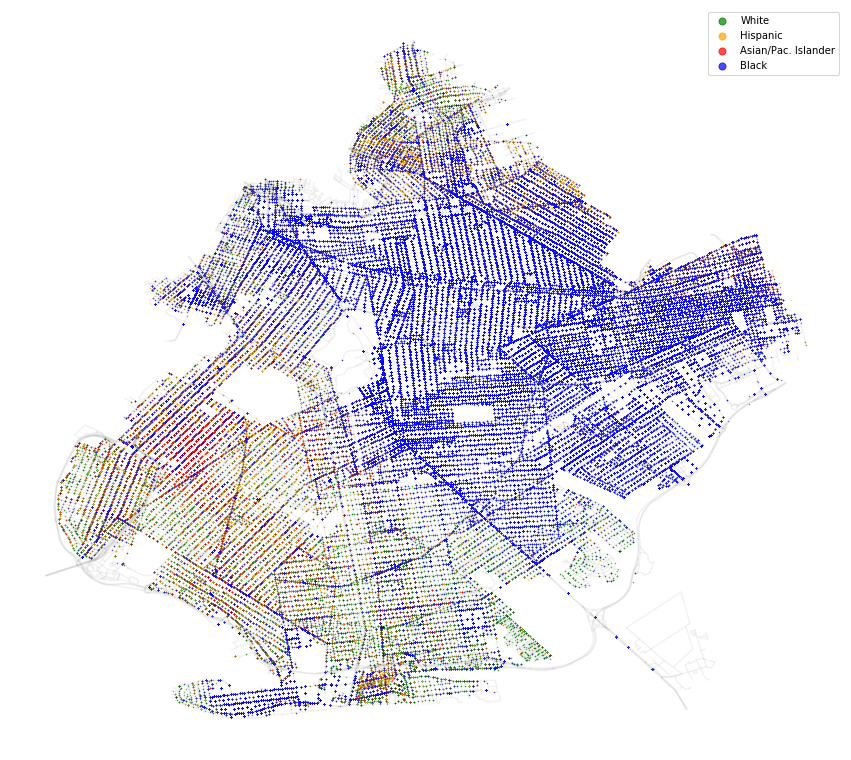

In [25]:
#This map is very flawed because it is just overlapping scatter plots
#The last race we scatter will be on top and will appear more prominient in the data

#All arrests by race
fig,ax = plt.subplots(figsize=(15,15))

bk_base.plot(ax=ax, color='grey', alpha=.1)

marker = '.'
alpha = .7
s = .5

ax.scatter(df[ (df['Latitude'] < 40.8) & 
              (df['ARREST_BORO'] == 'K') & 
              (df['PERP_RACE'] == 'WHITE') ]['Longitude'], 
            df[ (df['Latitude'] < 40.8) & 
               (df['ARREST_BORO'] == 'K') & 
               (df['PERP_RACE'] == 'WHITE') ]['Latitude'], 
            marker=marker, alpha=alpha, color='green', s=s, label='White')

ax.scatter(df[ (df['Latitude'] < 40.8) & 
              (df['ARREST_BORO'] == 'K') & 
              (df['PERP_RACE'].str.contains('HISPANIC')) ]['Longitude'], 
            df[ (df['Latitude'] < 40.8) & 
               (df['ARREST_BORO'] == 'K') & 
               (df['PERP_RACE'].str.contains('HISPANIC')) ]['Latitude'], 
            marker=marker, alpha=alpha, color='orange', s=s, label='Hispanic')

ax.scatter(df[ (df['Latitude'] < 40.8) & 
              (df['ARREST_BORO'] == 'K') & 
              (df['PERP_RACE'] == 'ASIAN / PACIFIC ISLANDER') ]['Longitude'], 
            df[ (df['Latitude'] < 40.8) & 
               (df['ARREST_BORO'] == 'K') & 
               (df['PERP_RACE'] == 'ASIAN / PACIFIC ISLANDER') ]['Latitude'], 
            marker=marker, alpha=alpha, color='red', s=s, label='Asian/Pac. Islander')

ax.scatter(df[ (df['Latitude'] < 40.8) & 
              (df['ARREST_BORO'] == 'K') & 
              (df['PERP_RACE'] == 'BLACK') ]['Longitude'], 
            df[ (df['Latitude'] < 40.8) & 
               (df['ARREST_BORO'] == 'K') & 
               (df['PERP_RACE'] == 'BLACK') ]['Latitude'], 
            marker=marker, alpha=alpha, color='blue', s=s, label='Black')
    
plt.legend(markerscale=20, loc='upper right')

declutter_axes(ax=ax)

plt.show()

In [26]:
#Just some checks to look at lat/lon data
print(len(df[['Latitude', 'Longitude']]))
print(len(df['Latitude'].unique()))
print(len(df['Latitude'].unique()))

5005855
100420
100420


In [27]:
5005855 / (365*3)

4571.557077625571

In [28]:
#get a set of columns that does not include lon/lat
cols = df.columns.to_list()
cols.remove('Latitude')
cols.remove('Longitude')
cols

['ARREST_KEY',
 'ARREST_DATE',
 'PD_CD',
 'PD_DESC',
 'KY_CD',
 'OFNS_DESC',
 'LAW_CODE',
 'LAW_CAT_CD',
 'ARREST_BORO',
 'ARREST_PRECINCT',
 'JURISDICTION_CODE',
 'AGE_GROUP',
 'PERP_SEX',
 'PERP_RACE',
 'X_COORD_CD',
 'Y_COORD_CD',
 'ARREST_YEAR',
 'ARREST_MONTH',
 'ARREST_DAY']

In [29]:
#find the percent of each each race present at each lon/lat
race_size = df.groupby(['Latitude','Longitude','PERP_RACE']).size()
race_pct = race_size.groupby(level=[0,1]).apply(lambda x: 100 * x / float(x.sum()))

In [30]:
race_pct

Latitude   Longitude   PERP_RACE               
40.498905  -74.241537  WHITE                       100.000000
40.498957  -74.244367  WHITE                       100.000000
40.499025  -74.240599  WHITE                       100.000000
40.499143  -74.243486  WHITE                       100.000000
40.499229  -74.243055  WHITE                       100.000000
                                                      ...    
40.915048  -73.908944  ASIAN / PACIFIC ISLANDER      5.636979
                       BLACK                        37.147689
                       HISPANIC                     37.955656
                       UNKNOWN                       0.394589
                       WHITE                        18.733559
Length: 272528, dtype: float64

In [31]:
#rename column 0 as 'race_pct'
df_race_pct = race_pct.reset_index().rename(columns={0:'race_pct'})

In [32]:
#return most common arrest race for each lon/lat
#1. groupby lon/lat and reutrn column of race_pct organized by max percent
#2. reset the index
#3. merge back with the original race pct dataframe to get the lat/lon values 
df_max_race = df_race_pct.groupby(['Latitude','Longitude'])['race_pct'].max().reset_index().merge(df_race_pct, on=['Latitude','Longitude','race_pct'])


In [33]:
#add boro column to max_race df
df_max_race_boro = df_max_race.merge(df[['Latitude','Longitude','ARREST_BORO']], on=['Latitude','Longitude'])

### Better Maps

Now we have a dataframe organized by each unqiue set of (long, lat, race) with a value for how common each race is at that unique longitude and latitude
With this unique information, we want to plot the following on a map:
- Color for the dominant race
- That color changes depending on how dominant it is at that lon/lat
- Does the color change depending on the make up of the races?
    - Black -> White -> Hispanic is diffent then White -> Hispanic -> Black?
    - or could it be compared to the racial breakdown of that area?
        - Black people are mis-represented in this arrest data by this percent...
        
I think final answer for now is to group by the majority race and then create a bubble that shows the size of arrests at that lat/lon location
- scatter by lat/lon and color by race category

In [34]:
df_max_race_boro['PERP_RACE'].value_counts(normalize=True)

BLACK                             0.573669
HISPANIC                          0.326626
WHITE                             0.079341
ASIAN / PACIFIC ISLANDER          0.019885
UNKNOWN                           0.000355
AMERICAN INDIAN/ALASKAN NATIVE    0.000108
OTHER                             0.000018
Name: PERP_RACE, dtype: float64

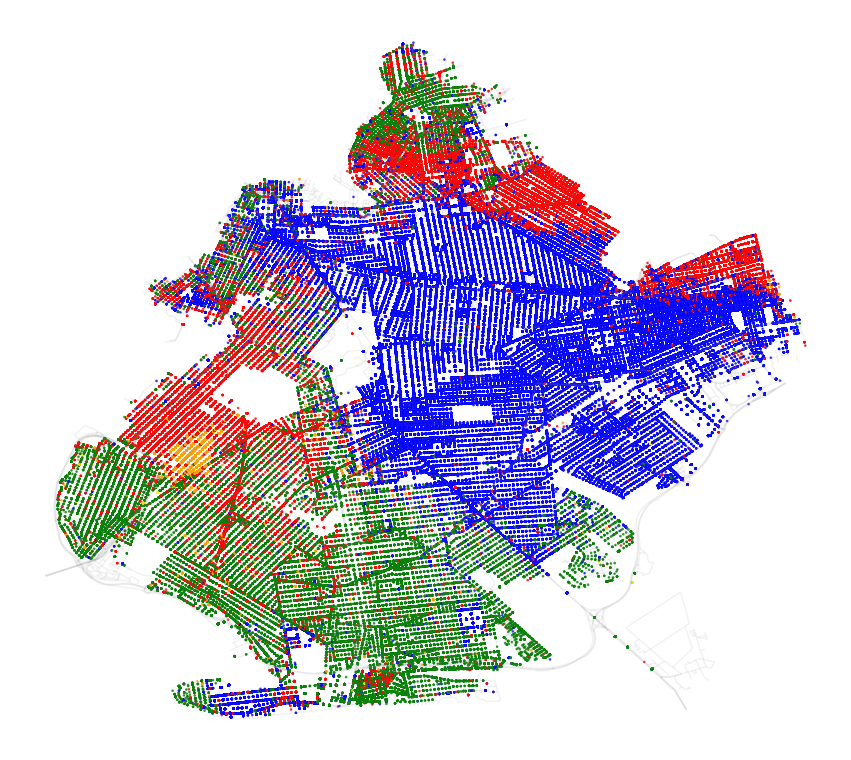

In [35]:
#map the MOST arrested race at each lat/lon
fig,ax = plt.subplots(figsize=(15,15))

bk_base.plot(ax=ax, color='grey', alpha=.1)

marker = '.'
alpha = .7
s = 10

colors = {'WHITE':'green', 'ASIAN / PACIFIC ISLANDER':'orange', 'HISPANIC':'red', 'BLACK':'blue', 
          'UNKNOWN':'yellow', 'AMERICAN INDIAN/ALASKAN NATIVE':'purple', 'OTHER':'black'}

ax.scatter(df_max_race_boro[(df_max_race_boro['ARREST_BORO'] == 'K') &
                            (df_max_race_boro['Latitude'] < 40.8)]['Longitude'], 
           df_max_race_boro[(df_max_race_boro['ARREST_BORO'] == 'K') &
                            (df_max_race_boro['Latitude'] < 40.8)]['Latitude'], 
           c=df_max_race_boro[(df_max_race_boro['ARREST_BORO'] =='K') &
                            (df_max_race_boro['Latitude'] < 40.8)]['PERP_RACE'].apply(lambda x: colors[x]), 
           alpha=alpha, marker=marker, s=s)

declutter_axes(ax=ax)

plt.show()

In [36]:
#map the MOST arrested race at each lat/lon and marker size changes depending on total number of arrests

In [37]:
num_arrests = df[(df['ARREST_BORO'] == 'K') & (df['Latitude'] < 40.8)].groupby(['Latitude','Longitude']).size().reset_index().rename(columns={0:'tot_arrests'})

In [38]:
brooklyn = df[(df['ARREST_BORO'] == 'K') & (df['Latitude'] < 40.8)]

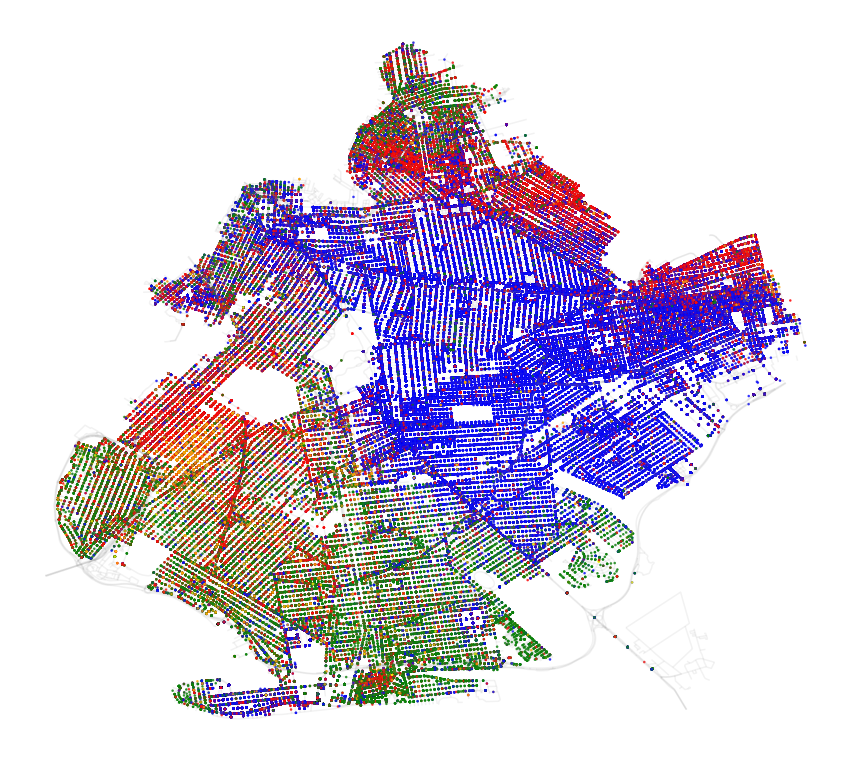

In [39]:
#map the MOST arrested race at each lat/lon
fig,ax = plt.subplots(figsize=(15,15))

bk_base.plot(ax=ax, color='grey', alpha=.1)

marker = '.'
alpha = .7
s = 10

colors = {'WHITE':'green', 'ASIAN / PACIFIC ISLANDER':'orange', 'HISPANIC':'red', 'BLACK':'blue', 
          'UNKNOWN':'yellow', 'AMERICAN INDIAN/ALASKAN NATIVE':'purple', 'OTHER':'black'}

ax.scatter(brooklyn['Longitude'], 
           brooklyn['Latitude'], 
           c=brooklyn['PERP_RACE'].apply(lambda x: colors[x]), 
           alpha=alpha, marker=marker, s=s)

declutter_axes(ax=ax)

plt.show()

In [490]:
brooklyn.head()

ARREST_KEY ARREST_DATE  PD_CD                                     PD_DESC  \
2    173113513  2017-12-31  849.0        NY STATE LAWS,UNCLASSIFIED VIOLATION   
5    173130583  2017-12-31  397.0             ROBBERY,UNCLASSIFIED,OPEN AREAS   
10   173128430  2017-12-31  101.0                                   ASSAULT 3   
11   173128428  2017-12-31  339.0  LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED   
12   173126364  2017-12-31  109.0                    ASSAULT 2,1,UNCLASSIFIED   

    KY_CD                     OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  \
2   677.0              OTHER STATE LAWS  LOC000000V          V           K   
5   105.0                       ROBBERY  PL 1601001          F           K   
10  344.0  ASSAULT 3 & RELATED OFFENSES  PL 1200002          M           K   
11  341.0                 PETIT LARCENY  PL 1552500          M           K   
12  106.0                FELONY ASSAULT  PL 1200501          F           K   

    ARREST_PRECINCT  ...  AGE_GROUP PERP_SEX PERP_RACE X_COORD_CD  Y_COORD_CD  \
2                73  ...      18-24        M     BLACK  1010719.0    186857.0   
5                73  ...      18-24        M     BLACK  1007524.0    188555.0   
10               83  ...      25-44        M  HISPANIC  1003807.0    195345.0   
11               61  ...        65+        F     WHITE   997477.0    154359.0   
12               60  ...        <18        F     BLACK   986771.0    148698.0   

     Latitude  Longitude  ARREST_YEAR  ARREST_MONTH  ARREST_DAY  
2   40.679525 -73.904572         2017            12          31  
5   40.684194 -73.916085         2017            12          31  
10  40.702840 -73.929467         2017            12          31  
11  40.590354 -73.952377         2017            12          31  
12  40.574825 -73.990927         2017            12          31  

[5 rows x 21 columns]

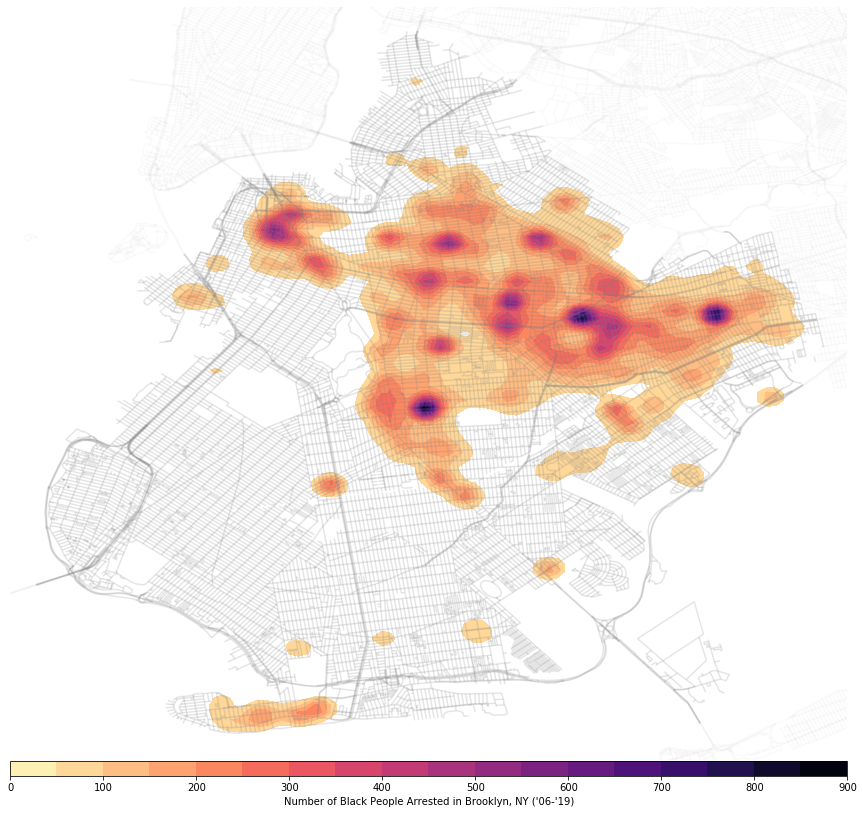

In [631]:
fig, ax = plt.subplots(figsize=(15,15))

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='2%', pad=.01)

#sample = 100
bk_sample = brooklyn[brooklyn['PERP_RACE'] == 'BLACK']#.sample(sample)
x = bk_sample['Longitude']
y = bk_sample['Latitude']
sns.kdeplot(x, y, ax=ax, shade=True, alpha=1, n_levels=20, cmap='magma_r', shade_lowest=False, zorder=2,
            cbar_ax=cax, cbar=True, 
            cbar_kws={'label':"Number of Black People Arrested in Brooklyn, NY ('06-'19)",
                      'orientation':'horizontal'})

bk_base.plot(ax=ax, color='grey', alpha=.2, zorder=3)
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)

ax.set_xlim(-74.050,-73.850)
ax.set_ylim(40.565,40.745)

declutter_axes(ax=ax)

#plt.savefig('figs/black_arrest_density.png', dpi=500, bbox_inches='tight')
plt.show()